In [1]:
import numpy as np
import matplotlib.pyplot as plt

import simon_64_128
import simon_64_128_simulation
import logger

from helper import KeyHypothesis
import helper
from measurement import Measurements

rng = np.random.default_rng()

In [2]:
NUM_MEASUREMENTS = 1000
VALS_PER_MEASUREMENT = 45
CORR_DIFF_THRESHOLD = 0.05

# Perform Simulated Measurements with random plaintexts

In [3]:
key = rng.integers(0, 2**32, 4, dtype=np.uint32)

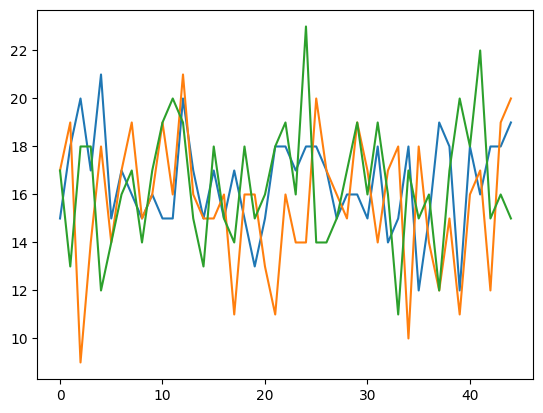

In [4]:
 # Perform 1000 simulated measurements
plaintexts = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers = np.zeros((NUM_MEASUREMENTS, VALS_PER_MEASUREMENT), dtype=np.uint32)


for i in range(NUM_MEASUREMENTS):
    pt = rng.integers(0, 2**32, 2, dtype=np.uint32)
    ct, log = simon_64_128.encrypt_block(pt, key)
    power = simon_64_128_simulation.log_to_simulated_power(log)

    plaintexts[i] = pt
    ciphertexts[i] = ct
    powers[i, :] = power

measurements = Measurements(plaintexts, ciphertexts, powers)

# Draw 3 simulated traces
plt.figure()
plt.plot(measurements[0].power)
plt.plot(measurements[1].power)
plt.plot(measurements[2].power)
plt.show()


# Simulated Measurement for 3 specific plaintexts

The graph shows that a plaintext of [FFFFFFFF, FFFFFFFF] will result in a high power consumption at the beginning. The plaintext [00000000, 00000000] has a low power consumption at the beginning.

In the beginning, the plaintexts [00000000, 00000000] and [00000001, 00000000] have a similar graph.

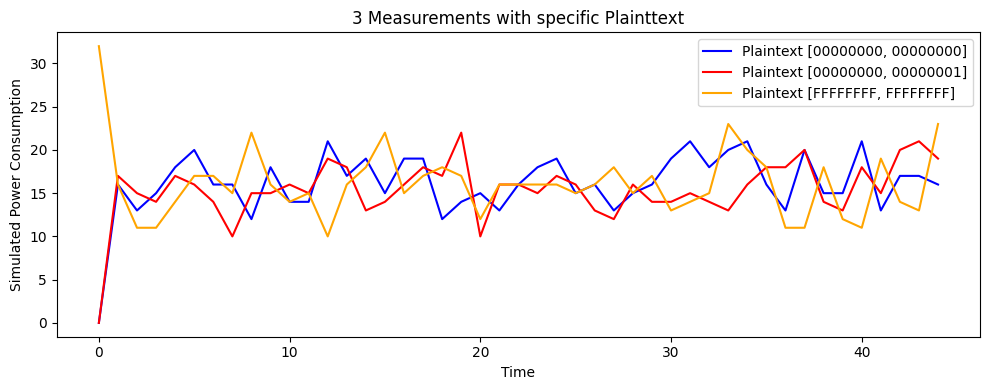

In [5]:
plaintext1 = np.array([0,0], dtype=np.uint32)
_, log1 = simon_64_128.encrypt_block(plaintext1, key)

plaintext2 = np.array([0,1], dtype=np.uint32)
_, log2 = simon_64_128.encrypt_block(plaintext2, key)

plaintext3 = np.array([0xFFFFFFFF,0xFFFFFFFF], dtype=np.uint32)
_, log3 = simon_64_128.encrypt_block(plaintext3, key)

current_consumption1 = simon_64_128_simulation.log_to_simulated_power(log1)
current_consumption2 = simon_64_128_simulation.log_to_simulated_power(log2)
current_consumption3 = simon_64_128_simulation.log_to_simulated_power(log3)

plt.figure(figsize=(10,4))
vals1 = current_consumption1
vals2 = current_consumption2
vals3 = current_consumption3

plt.plot(vals1, color='blue', label='Plaintext [00000000, 00000000]')
plt.plot(vals2, color='red', label='Plaintext [00000000, 00000001]')
plt.plot(vals3, color='orange', label='Plaintext [FFFFFFFF, FFFFFFFF]')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with specific Plainttext")
plt.tight_layout()
plt.show()

# Attack

In [6]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

promising_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    sub_hypos: list[KeyHypothesis] = []

    for h in promising_hypos:
        sub_hypos.extend(h.get_sub_hypos())

    print(f"Find correlations for {len(sub_hypos)} hypotheses.")

    helper.calc_corrs_for_hypos(sub_hypos, measurements)
    promising_hypos = helper.filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)

    print(f"Found {len(promising_hypos)} promising hypotheses.")
    for hypo in promising_hypos:
        print(f"{helper.array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            print(f"Extracted Key: {helper.array_to_hex_str(extracted_key)}")
            break
else:
    print("Could not determine key")


Perform Attack Step 1/16
Find correlations for 256 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00000028: correlation: 0.4982678409156142
0x00000000 0x00000000 0x00000000 0x000000D7: correlation: -0.4982678409156142
Perform Attack Step 2/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x0000DA28: correlation: 0.7189302245667497
0x00000000 0x00000000 0x00000000 0x000025D7: correlation: -0.7189302245667497
Perform Attack Step 3/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x0061DA28: correlation: 0.8626512069956184
0x00000000 0x00000000 0x00000000 0x009E25D7: correlation: -0.8626512069956184
Perform Attack Step 4/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0xB761DA28: correlation: 1.0010010010009966
0x00000000 0x00000000 0x00000000 0x489E25D7: correlation: -1.0010010010009966
Perform 

In [7]:
print(f"Actual key:     {helper.array_to_hex_str(key)}")
print(f"Extracted key:  {helper.array_to_hex_str(key)}")
print(f"Differences:    {helper.array_to_hex_str(extracted_key ^ key)}")

Actual key:     0x872BCF95 0x96423C5D 0x7E952B92 0xB761DA28
Extracted key:  0x872BCF95 0x96423C5D 0x7E952B92 0xB761DA28
Differences:    0x00000000 0x00000000 0x00000000 0x00000000


# Attack Insights

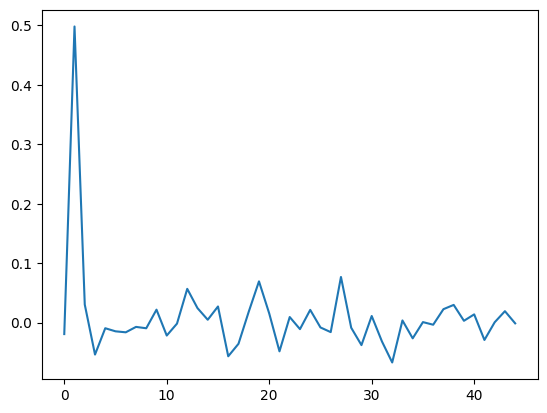

In [15]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] |= guessed_byte


expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(measurements.plaintext, guessed_key, 0, np.uint32(0xFF))
correlations = helper.calc_corrs(expected_hws, measurements.power)

plt.figure()
plt.plot(correlations[0])
plt.show()

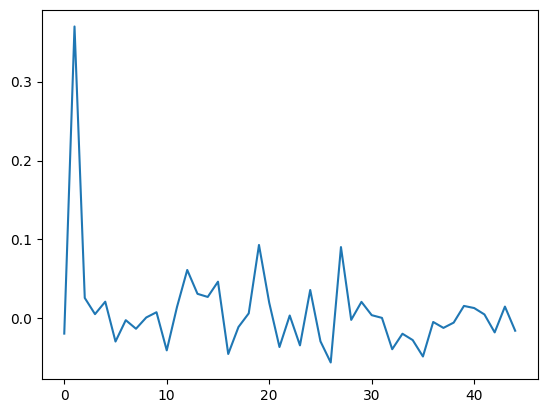

In [18]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF + 55
guessed_key[3] |= guessed_byte


expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(measurements.plaintext, guessed_key, 0, np.uint32(0xFF))
correlations = helper.calc_corrs(expected_hws, measurements.power)

plt.figure()
plt.plot(correlations[0])
plt.show()

Find correlations for 256 hypotheses.


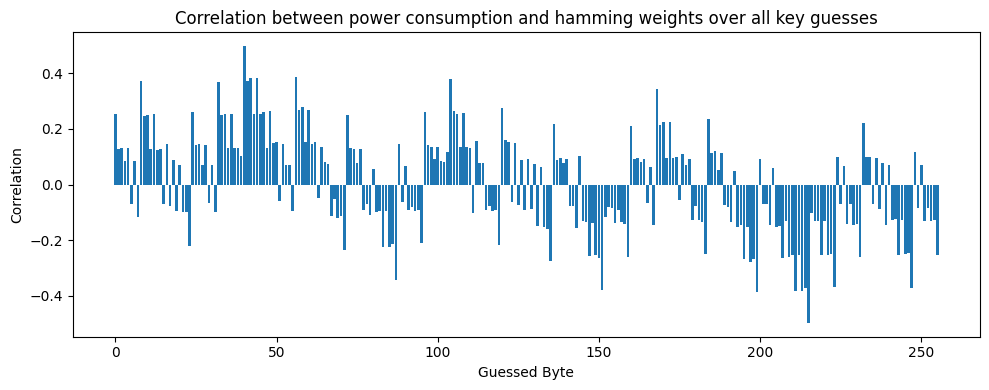

In [19]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

hypos = start_hypo.get_sub_hypos()

print(f"Find correlations for {len(hypos)} hypotheses.")

helper.calc_corrs_for_hypos(hypos, measurements)

corrs = [h.corr for h in hypos]
    
plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Guessed Byte")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights over all key guesses")
plt.tight_layout()
plt.show()